# Social Networks

topic: QAnon

python=3.7

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import re
from joblib import dump, load
from tldextract import extract
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Construct reply-comment network

### kcore = 1

In [2]:
df = pd.read_csv("data/debunking_comments[keyword=QAnon][lang=en].csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14637 entries, 0 to 14636
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   created_utc   14637 non-null  object
 1   author        14637 non-null  object
 2   subreddit     14637 non-null  object
 3   body          14637 non-null  object
 4   parent_id     14637 non-null  object
 5   subreddit_id  14637 non-null  object
 6   id            14637 non-null  object
 7   lang          14637 non-null  object
dtypes: object(8)
memory usage: 914.9+ KB


In [3]:
# for subbmission author mapping
comment_user_list = df[['parent_id']]
comment_user_list['id'] = comment_user_list['parent_id'].str.replace('^t\d+_', '')
comment_user_list.head(5)

parent_id       id
0  t1_fm2lpvw  fm2lpvw
1  t1_fm3hf2w  fm3hf2w
2  t1_fm1innf  fm1innf
3   t3_fs4k2e   fs4k2e
4  t1_fm4q1de  fm4q1de

In [4]:
import os
import re
from datetime import datetime

# file path contains all the files of reddit comment data
folder_path = '../data/submission'  
  
# find all the csv files in range
start_date = datetime.strptime("2020-04", "%Y-%m")
end_date = datetime.strptime("2021-04", "%Y-%m")
date_str_pattern = r'submission\[(.*?)\]\.csv'

# empty DataFrame to save all the data
sub_data = pd.DataFrame()  

all_id = set(comment_user_list['id']).union(set(df['id']))
files = os.listdir(folder_path)

for file in files:  
    mtch = re.search(date_str_pattern, file)
    if mtch:
        # get date from file name
        date_str = mtch.group(1)
        file_date = datetime.strptime(date_str, '%Y-%m')
        if start_date <= file_date <= end_date:
            print(file)
            df1 = pd.read_csv(folder_path + '/' + file)  
            df1 = df1[df1['id'].isin(all_id)]   # only keep IDs appeared in comments
            sub_data = sub_data.append(df1, ignore_index=True)  

submission[2020-07].csv
submission[2021-01].csv
submission[2020-10].csv
submission[2021-04].csv
submission[2021-02].csv
submission[2020-05].csv
submission[2020-06].csv
submission[2021-03].csv
submission[2020-11].csv
submission[2020-09].csv
submission[2020-04].csv
submission[2020-12].csv
submission[2020-08].csv


In [5]:
sub_data.info() # select the colums you need

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357 entries, 0 to 4356
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   author_flair_css_class  4306 non-null   object
 1   is_self                 4357 non-null   object
 2   archived                4357 non-null   object
 3   secure_media_embed      4357 non-null   object
 4   author_flair_text       4311 non-null   object
 5   locked                  4357 non-null   object
 6   spoiler                 4357 non-null   object
 7   author                  4357 non-null   object
 8   gilded                  4357 non-null   object
 9   hide_score              4357 non-null   object
 10  stickied                4357 non-null   object
 11  id                      4357 non-null   object
 12  distinguished           4357 non-null   object
 13  quarantine              4357 non-null   object
 14  selftext                2100 non-null   object
 15  medi

In [26]:
sub_data.sample(5)

author_flair_css_class is_self archived secure_media_embed  \
455      northcarolina-flag   False    False                 {}   
3015                   None    True     True                 {}   
12                     None   False     True                 {}   
4034                   None    True     True                 {}   
2075                   None    True    False                 {}   

             author_flair_text locked spoiler                 author gilded  \
455   :flag-nc: North Carolina  False   False  u/LittlePlasticCastle      0   
3015                      None  False   False             u/ABS_TRAC      0   
12                        None  False   False  u/stupidstupidreddit2      0   
4034                      None  False   False       u/cherishedlarry      0   
2075                      None  False   False          u/grotedongus      0   

     hide_score stickied      id distinguished quarantine  \
455       False    False  kvpc4w          None      False   
3015      False    False  jqri0p          None      False   
12        False    False  hkuhzf          None      False   
4034      False    False  i77m6e          None      False   
2075      False    False  lut0fh          None      False   

                                               selftext media_embed  
455                                                 NaN          {}  
3015  I’m not sure what to do... I’m so deeply torn ...          {}  
12                                                  NaN          {}  
4034  I've been going through some threads on here r...          {}  
2075  So I wanna start by saying the post on reddit ...          {}

In [6]:
sub_data.drop_duplicates(['id', 'author'], inplace=True)

In [9]:
# create a dictionary of {id:author}
sub_id_to_author = dict(zip(sub_data['id'], sub_data['author']))

# use .map to map the submission authors' information
comment_user_list['submission_author'] = comment_user_list['id'].map(sub_id_to_author)

In [10]:
#  map the comment authors' information
comment_id_to_author = dict(zip(df['parent_id'], df['author']))
comment_user_list['comment_author'] = comment_user_list['parent_id'].map(comment_id_to_author) 

In [11]:
comment_user_list_notna = comment_user_list.dropna()
comment_user_list_notna

parent_id      id       submission_author   comment_author
320    t3_gbhol2  gbhol2           u/Lonestar767         Atomica1
321    t3_gbkm6r  gbkm6r              u/Atomica1         Atomica1
322    t3_gbkr68  gbkr68              u/Atomica1         Atomica1
329    t3_gccams  gccams  u/Incredible_Bendy_Man     graneflatsis
330    t3_gblm6r  gblm6r               u/raxemsb   TableTopFarmer
...          ...     ...                     ...              ...
14621  t3_n1y1pp  n1y1pp             u/[deleted]          Lyn1987
14624  t3_n1spcs  n1spcs           u/justlogmeon      Burritoledo
14625  t3_n1sspq  n1sspq              u/brjh1990     CarlsManager
14633  t3_n1u6d1  n1u6d1        u/GenerationXero  FlyingFootStomp
14635  t3_n20jfb  n20jfb          u/TrumpSharted       Blueivy216

[4725 rows x 4 columns]

In [12]:
# construct edge list that contains retweet-comment data
rt_list =comment_user_list[comment_user_list['parent_id'].notnull()]
print(len(rt_list))

#author:the account name of the poster
#id:this item's identifier, e.g. "8xwlg"
#parent_id:ID of the thing this comment is a reply to, either the link or a comment in it
# edge list
#edge_list = pd.concat([comment_user_list['parent_id'], all_data['id'], axis=1)

edge_list = pd.DataFrame({  'source':rt_list['submission_author'], 'target':rt_list['comment_author']   })

14637


In [13]:
edge_list_notnull = edge_list.dropna()

In [14]:
edge_list_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4725 entries, 320 to 14635
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  4725 non-null   object
 1   target  4725 non-null   object
dtypes: object(2)
memory usage: 110.7+ KB


In [16]:
edge_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14637 entries, 0 to 14636
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  4725 non-null   object
 1   target  14637 non-null  object
dtypes: object(2)
memory usage: 343.1+ KB


In [20]:
edge_list

source              target
0                   NaN        drugzBadMkay
1                   NaN               Kafke
2                   NaN      CromulentInPDX
3                   NaN               PrevG
4                   NaN             Unvolta
...                 ...                 ...
14632               NaN            Goop1995
14633  u/GenerationXero     FlyingFootStomp
14634               NaN  i-wanted-that-iced
14635    u/TrumpSharted          Blueivy216
14636               NaN             Fredex8

[14637 rows x 2 columns]

In [ ]:
 #turn to the the gephi
D = nx.from_pandas_edgelist(edge_list, create_using=nx.DiGraph)    
nx.write_gexf(D, "data/reply_networks[plat=Reddit][topic=QAnon].gexf")  

### kcore = 2

In [21]:
# remove the self cycle
D.remove_edges_from(nx.selfloop_edges(D))

# caculate the number of k_core=2
k_core_2 = nx.k_core(D, k=2)

In [22]:
k_core_2.number_of_nodes()
k_core_2.number_of_edges()

577

In [23]:
in_degrees = dict(k_core_2.in_degree())

# sort the nodes by their degree
sorted_nodes_by_in_degree = sorted(in_degrees, key=in_degrees.get, reverse=True)

In [24]:
for node in sorted_nodes_by_in_degree[:10]:
    print("Node:", node, "In-Degree:", in_degrees[node])

Node: autotldr In-Degree: 15
Node: SnapshillBot In-Degree: 9
Node: graneflatsis In-Degree: 8
Node: AutoModerator In-Degree: 6
Node: kusuriurikun In-Degree: 5
Node: Fillupontacoz In-Degree: 5
Node: modilion In-Degree: 4
Node: Nervous_Tomatillo_50 In-Degree: 4
Node: twitterInfo_bot In-Degree: 4
Node: tehdeej In-Degree: 4


In [ ]:
nx.write_gexf(k_core_2, "data/reply_networks[core=2][plat=Reddit][topic=QAnon].gexf")  

## Communities analysis

In [ ]:
# gephi nodes dataframe
vexes = pd.read_csv("/mnt/data/wenlu/reddit-new/nodes-RC-16election(moduralarity=3).csv")
print(vexes.shape)
vexes.sample(5)

(27505, 6)


Id               Label  modularity_class  indegree  \
6524    u/jonnythaiwongy9   u/jonnythaiwongy9              1552         1   
15147      u/catholichelp      u/catholichelp              6041         2   
12367       u/QuantoFarto       u/QuantoFarto              5425         1   
22173          u/zzzebreh          u/zzzebreh              5967         1   
2391   u/thepriceofaslave  u/thepriceofaslave               530         1   

       outdegree  degree  
6524           0       1  
15147          0       2  
12367          0       1  
22173          0       1  
2391           1       2

In [ ]:
# Top eight communities with the highest number of community vertices
# [(Community number, Percentage of number of community vertices)]
top8_list = [(5,0.1272),(168,0.0595),(173,0.0558),(5834,0.0445),(1628,0.0217),(559,0.0183),(4820,0.0159),(6041,0.0158)]

# get the top 8 ones
communities_top8 = []
for i in range(len(top8_list)):
    communities_top8.append(vexes[vexes['modularity_class'] == top8_list[i][0]])

# sort by their ingree
for x in communities_top8:
    x.sort_values(by='indegree', ascending=False, inplace=True)
    x.reset_index(inplace=True)

## Text Cleaning

In [ ]:
# Remove characters such as punctuation, URLs, and line breaks
import string

def wordopt(text):
    text = text.lower()
    text = re.sub(r'\\n', '', text) 
    text = re.sub('\[.*?\]', '', text) # Remove strings enclosed in parentheses
    text = re.sub('https?://\S+|www\.\S+', '', text) # drop websites
    text = re.sub("\\W"," ",text) # Remove non-word characters
    text = re.sub('<.*?>+', '', text) # Remove HTML, XML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Removes all punctuation marks from the text
    text = re.sub('\n', '', text) # Remove line breaks
    text = re.sub('\w*\d\w*', '', text) # Remove alphanumeric "words"
    return text

df = pd.read_csv("data/debunking_comments[keyword=QAnon][lang=en].csv")
df['body'] = df.body.apply(lambda x : wordopt(x))

In [ ]:
# Lemmatization

# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')
import nltk
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

def word_lemmatizer(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [lemm.lemmatize(w) for w in token_text]
    join_text = ' '.join(remove_stop)
    return join_text

df['body'] = df.body.apply(lambda x : word_lemmatizer(x))

In [ ]:
# Noise removal
# nltk.download('stopwords')
from nltk.corpus import stopwords
Word_STOPWORDS = ["e", "te", "i", "me", "qe", "ne", "nje", "a", "per", "sh", "nga", "ka", "u", "eshte", "dhe", "shih", "nuk",
             "m", "dicka", "ose", "si", "shume", "etj", "se", "pa", "sipas", "s", "t", "dikujt", "dike", "mire", "vet",
             "bej", "ai", "vend", "prej", "ja", "duke", "tjeter", "kur", "ia", "ku", "ta", "keq", "dy", "ben", "bere",
             "behet", "dickaje", "edhe", "madhe", "la", "sa", "gjate", "zakonisht", "pas", "veta", "mbi", "disa", "iu",
             "mos", "c", "para", "dikush", "gje", "be", "pak", "tek", "fare", "beri", "po", "bie", "k", "do", "gjithe",
             "vete", "mund", "kam", "le", "jo", "beje", "tij", "kane", "ishte", "jane", "vjen", "ate", "kete", "neper",
             "cdo", "na", "marre", "merr", "mori", "rri", "deri", "b", "kishte", "mban", "perpara", "tyre", "marr",
             "gjitha", "as", "vetem", "nen", "here", "tjera", "tjeret", "drejt", "qenet", "ndonje", "nese", "jap",
             "merret", "rreth", "lloj", "dot", "saj", "nder", "ndersa", "cila", "veten", "ma", "ndaj", "mes", "ajo",
             "cilen", "por", "ndermjet", "prapa", "mi", "tere", "jam", "ashtu", "kesaj", "tille", "behem", "cilat",
             "kjo", "menjehere", "ca", "je", "aq", "aty", "prane", "ato", "pasur", "qene", "cilin", "teper", "njera",
             "tej", "krejt", "kush", "bejne", "ti", "bene", "midis", "cili", "ende", "keto", "kemi", "sic", "kryer",
             "cilit", "atij", "gjithnje", "andej", "siper", "sikur", "ketej", "ciles", "ky", "papritur", "ua",
             "kryesisht", "gjithcka", "pasi", "kryhet", "mjaft", "ketij", "perbashket", "ata", "atje", "vazhdimisht",
             "kurre", "tone", "keshtu", "une", "sapo", "rralle", "vetes", "ishin", "afert", "tjetren", "ketu", "cfare",
             "to", "anes", "jemi", "asaj", "secila", "kundrejt", "ketyre", "pse", "tilla", "mua", "nepermjet", "cilet",
             "ndryshe", "kishin", "ju", "tani", "atyre", "dic", "yne", "kudo", "sone", "sepse", "cilave", "kem", "ty",
             "t'i", "nbsp", "tha", "re", "the", "jr", "t", "n"]
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
text_unknows= Word_STOPWORDS
stop.update(text_unknows)


from bs4 import BeautifulSoup
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    '''Removing the square brackets'''
    return re.sub('\[[^]]*\]', '', text)

def remove_between_square_brackets(text):
    '''Removing URL's'''
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    '''Removing the stopwords from text'''
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    '''Removing the noisy text'''
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

df['body'] = df.body.apply(lambda x : denoise_text(x))

In [ ]:
# Remove punctuation
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

df['body'] = df['body'].apply(punctuation_removal)

In [ ]:
# Combine each user's own text
user_texts = df.groupby(by='author').agg(text=("body", lambda x: ' '.join(set(x)))) #','change' '
user_texts.reset_index(drop=False, inplace=True)
user_texts.to_csv("data/user_texts[info=debunk][text=comment][topic=QAnon].csv", index=False)
user_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10591 entries, 0 to 10590
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  10591 non-null  object
 1   text    10591 non-null  object
dtypes: object(2)
memory usage: 165.6+ KB


## LIWC

In [ ]:
# Read the LIWC dictionary
import liwc
liwcPath = r'data/LIWC2015_English.dic'
parse, category_names = liwc.load_token_parser(liwcPath)

from sklearn.feature_extraction.text import TfidfVectorizer

def liwc_analyse(user_text):
    
    global parse
    corpus = []
    words = []

    review = re.sub('[^a-zA-Z0-9]', ' ', user_text['text'])
    review = review.split()
    review = list(category for token in review for category in parse(token))
    statements = ' '.join(review)
    corpus.append(statements)
    words.append(review)
    
    # TF-IDF
    try:
        vectorizer = TfidfVectorizer(max_features=5000)
        X_fit = vectorizer.fit(corpus)
        X_transformed = X_fit.transform(corpus)

        features = vectorizer.get_feature_names()
        df_count = pd.DataFrame(X_transformed.toarray(),columns = features)
    except:
        df_count = pd.DataFrame()

    user_text = pd.DataFrame(user_text).T
    user_text.reset_index(drop=True, inplace=True)
    
    return pd.concat([user_text, df_count], axis=1) 

# user_rt_sentiments = user_texts.apply(liwc_analyse, axis=1).tolist()

In [37]:
from pandarallel import pandarallel

# Initialization
pandarallel.initialize(progress_bar=True, nb_workers=8)

# Parallel apply
user_rt_sentiments = user_texts.parallel_apply(liwc_analyse, axis=1).tolist()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:

user_comment_sentiments_dict = {a['author'][0]:dict(pd.Series(a.T[0])) for a in user_rt_sentiments}

dump(user_comment_sentiments_dict, "pkl/user_comment_sentiments_dict[topic=QAnon].pkl")
len(user_comment_sentiments_dict)

10591

## Perspective

In [ ]:
perspective_res_path = "data/perspective_api_results[info=debunk][text=comment][topic=QAnon].csv"
perspective_res = pd.read_csv(perspective_res_path)
perspective_res.info()

def get_score_from_json(x):

    if pd.isna(x):
        return None
    s = re.search("'score': {'value': (.+?),", x)
    return float(s.group(1))

perspective_res['toxicity_score'] = perspective_res['perspective_api_results'].apply(get_score_from_json)
perspective_res.to_csv(perspective_res_path, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10591 entries, 0 to 10590
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   10591 non-null  object 
 1   text                     10567 non-null  object 
 2   perspective_api_results  10516 non-null  object 
 3   toxicity_score           10516 non-null  float64
dtypes: float64(1), object(3)
memory usage: 331.1+ KB


## Toxicity-Sentiment Distribution

In [2]:
# adding sentiment scores and toxicity score columns to DataFrame user_texts
user_texts = pd.read_csv("data/user_texts[info=debunk][text=comment][topic=QAnon].csv")
score_dict = load("pkl/user_comment_sentiments_dict[topic=QAnon].pkl")
perspective_res = pd.read_csv("data/perspective_api_results[info=debunk][text=comment][topic=QAnon].csv", 
                              index_col='author')

def get_user_toxicity(u, perspective_res):
    try:
        tmp = perspective_res['toxicity_score'][u]
        if pd.isna(tmp):
            raise
        return tmp
    except:
        return None
    
def get_user_liwc_score(u, sentiment:str, score_dict):
    try:
        tmp = score_dict[u][sentiment]
        return tmp
    except:
        return None

user_texts['positive_score'] = user_texts['author'].apply(get_user_liwc_score, args=('positive',score_dict))
user_texts['negative_score'] = user_texts['author'].apply(get_user_liwc_score, args=('negative',score_dict))
user_texts['affect_score'] = user_texts['author'].apply(get_user_liwc_score, args=('affect',score_dict))
user_texts['toxicity_score'] = user_texts['author'].apply(get_user_toxicity, args=(perspective_res,))
user_texts.to_csv("data/user_texts[info=debunk][text=comment][topic=QAnon].csv", index=False)
user_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10591 entries, 0 to 10590
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   author          10591 non-null  object 
 1   text            10567 non-null  object 
 2   positive_score  9130 non-null   float64
 3   negative_score  9138 non-null   float64
 4   affect_score    10073 non-null  float64
 5   toxicity_score  10516 non-null  float64
dtypes: float64(4), object(2)
memory usage: 496.6+ KB


In [ ]:
# draw 3D kernel density heatmap
import numpy as np
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import plotly.io as pio


def toxicity_sentiment_heatmap_3d(data, sentiment, title='Debunking', xlim=0.5, ylim=1):
   
    df = data
    df = df[df[sentiment+'_score'].notna() & df['toxicity_score'].notna()]   
    data = np.vstack([df[sentiment+'_score'].values, df['toxicity_score'].values])

    kde = gaussian_kde(data)

    xgrid = np.linspace(0, xlim, 100)
    ygrid = np.linspace(0, ylim, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

    fig = go.Figure(data=[go.Surface(z=Z.reshape(Xgrid.shape), x=Xgrid, y=Ygrid, colorscale='Jet', 
                                     colorbar=dict(thickness=25, len=0.618, tickfont=dict(size=11)))])

    fig.update_layout(
            title=dict(x=0.5, y=0.97, font=dict(size=22), text=title, ),
            autosize=False,
            width=450, height=400,
            margin=dict(l=0, r=0, b=0, t=30), 
    )
    axis_title_size = 14
    axis_tick_size = 11
    fig.update_scenes(
        xaxis=dict(
            title=dict(
                text=(sentiment + ' score').title(),
                font=dict(size=axis_title_size),
            ), 
            tickfont=dict(size=axis_tick_size), 
            nticks=6,
        ),
        yaxis=dict(
            title=dict(
                text='toxicity score'.title(),
                font=dict(size=axis_title_size),
            ), 
            tickfont=dict(size=axis_tick_size), 
            nticks=6,
        ),
        zaxis=dict(
            title=dict(
                text='Kernel Density'.title(),
                font=dict(size=axis_title_size),
            ), 
            tickfont=dict(size=axis_tick_size), 
            nticks=6,
        ),
        camera=dict(
            center=dict(x=0, y=-0.20, z=0.03,),
            eye=dict(x=12, y=-10, z=7),
            projection=dict(type="orthographic"),
        ),
        aspectratio=dict(x=1.28, y=1.28, z=1.28),
    )
    
    return fig

In [4]:
fig = toxicity_sentiment_heatmap_3d(user_texts, 'positive')
fig.show()
pio.write_image(
    fig, 
    'pic/heatmap[xy=positive&toxicity][info=debunking][topic=QAnon][platform=Reddit].png', 
    scale=5
)

In [5]:
fig = toxicity_sentiment_heatmap_3d(user_texts, 'negative')
fig.show()
pio.write_image(
    fig, 
    'pic/heatmap[xy=negative&toxicity][info=debunking][topic=QAnon][platform=Reddit].png', 
    scale=5
)

In [6]:
fig = toxicity_sentiment_heatmap_3d(user_texts, 'affect', xlim=1)
fig.show()
pio.write_image(
    fig, 
    'pic/heatmap[xy=affect&toxicity][info=debunking][topic=QAnon][platform=Reddit].png', 
    scale=5
)

## Hump Analysis

### Toxicity-Affect

In [ ]:
from scipy.stats import gaussian_kde

def draw_toxicity_sentiment_contour(
        data: pd.DataFrame, 
        sentiment: str, 
        xlim,
        ylim,
        figsize=(10, 15), 
        level_num=10
    ):
    
    df = data.dropna(subset=[sentiment + '_score', 'toxicity_score']).reset_index(drop=True, inplace=False)
    x = df[sentiment + '_score']
    y = df['toxicity_score']


    xy = np.vstack([x,y])
    kde = gaussian_kde(xy)


    xmin, ymin = xy.min(axis=1)
    xmax, ymax = xy.max(axis=1)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])


    Z = np.reshape(kde(positions).T, X.shape)
    levels = np.linspace(np.min(Z), np.max(Z), level_num)


    plt.figure(figsize=figsize)
    contour_set = plt.contour(X, Y, Z, levels=levels)
    plt.clabel(contour_set, inline=False, fontsize=8) 
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

 
    return contour_set

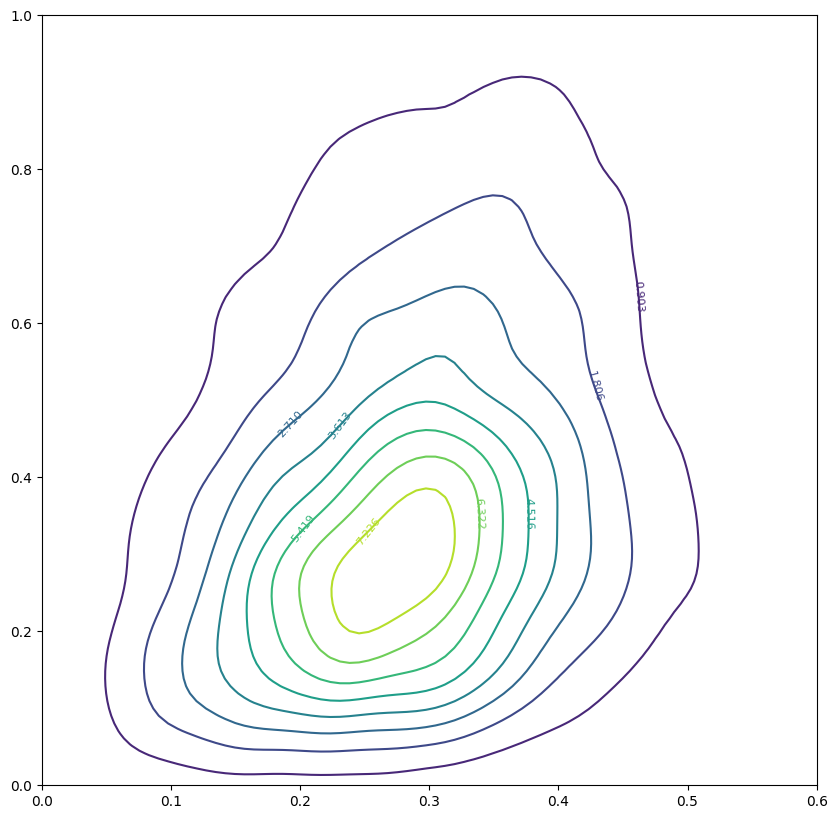

In [ ]:
contour = draw_toxicity_sentiment_contour(
            user_texts, 
            'affect', 
            xlim=(0, 0.6), ylim=(0, 1), 
            figsize=(10, 10)
        )

In [ ]:

print(contour.levels)

[1.98384712e-09 9.03189384e-01 1.80637877e+00 2.70956815e+00
 3.61275753e+00 4.51594691e+00 5.41913630e+00 6.32232568e+00
 7.22551506e+00 8.12870444e+00]


selected level: 7.225515061705114


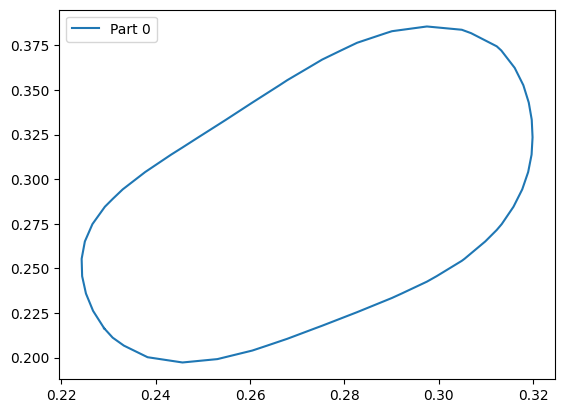

In [ ]:

order = 8
print(f"selected level: {contour.levels[order]}")
segments = contour.allsegs[order]
for j, segment in enumerate(segments):
    plt.plot(segment[:, 0], segment[:, 1], label=f'Part {j}')

plt.legend()
plt.show()

In [ ]:
import matplotlib.path as mpath


part = 0
segment = segments[part]


path = mpath.Path(segment)
df = user_texts.dropna(subset=['affect_score', 'toxicity_score']).reset_index(drop=True, inplace=False)
df['dense_area'] = path.contains_points(df[['affect_score', 'toxicity_score']].values)


points = df[df['dense_area']]
points.shape

(954, 7)

In [ ]:
points.to_csv("data/points[level_no>=8].csv", index=False)

In [ ]:
df = pd.read_csv("data/debunking_comments[keyword=QAnon][lang=en].csv")
df[df['author'].isin(points['author'])]['author'].value_counts()

Fillupontacoz           254
AutoModerator           119
musicroyaldrop           25
Poemy_Puzzlehead         23
thinkingdoing            21
                       ... 
frequenttimetraveler      1
zenithfury                1
LedParade                 1
Titty_Salad               1
GardenCaviar              1
Name: author, Length: 954, dtype: int64

## dpi adjust

In [7]:
from PIL import Image
import os

def set_dpi_for_all_image(directory, dpi):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            img = Image.open(file_path)
            img.save(file_path, dpi=(dpi, dpi))

set_dpi_for_all_image('pic', 300)